In [ ]:
!pip install nltk
!pip install keras
!pip install gensim
!pip install seaborn




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import brown, conll2000, treebank, masc_tagged
from gensim.models import KeyedVectors
import gensim.downloader as api
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM ,Input,GRU,Bidirectional,RNN,SimpleRNN,TimeDistributed
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



# 1.preprocess Data

##Load Data

In [ ]:
import nltk
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('masc_tagged')

# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
masc_corpus = masc_tagged.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus + masc_corpus


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package masc_tagged to /root/nltk_data...


In [ ]:
# let's look at the data
# each sentence in the list is a full statement, each word with their Pos
tagged_sentences[30]

[('``', '.'),
 ('There', 'DET'),
 ("'s", 'VERB'),
 ('no', 'DET'),
 ('question', 'NOUN'),
 ('that', 'ADP'),
 ('some', 'DET'),
 ('of', 'ADP'),
 ('those', 'DET'),
 ('workers', 'NOUN'),
 ('and', 'CONJ'),
 ('managers', 'NOUN'),
 ('contracted', 'VERB'),
 ('asbestos-related', 'ADJ'),
 ('diseases', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('Darrell', 'NOUN'),
 ('Phillips', 'NOUN'),
 (',', '.'),
 ('vice', 'NOUN'),
 ('president', 'NOUN'),
 ('of', 'ADP'),
 ('human', 'ADJ'),
 ('resources', 'NOUN'),
 ('for', 'ADP'),
 ('Hollingsworth', 'NOUN'),
 ('&', 'CONJ'),
 ('Vose', 'NOUN'),
 ('.', '.')]

In [ ]:
# POS
set([pos[1] for list_ in tagged_sentences  for pos in list_ ])

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

## Divide data in words (X) and tags (Y)
Since this many to many problem , in addition the length of input sequence Tx = the length of output sequence Ty , each data point will be a different sentence of the corpora .
Each data point will have multiple words in the input sequence . This is what we will refer to as X .
Each word will have its corresponding tag in the output sequence . This what we will refer to as Y .  

Sample Dataset :

X : Mr Vinken is chairman of Elsevier

Y : NOUN NOUN VERB NOUN ADP NOUN



In [ ]:
X = [] # store input Sequence
Y = [] # store output Sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for word in sentence:
        X_sentence.append(word[0])
        Y_sentence.append(word[1])

    X.append(X_sentence)
    Y.append(Y_sentence)


In [ ]:
# many to many and Tx = Ty
if len(X[0])==len(Y[0]) :
  print('this many to many problem , with Tx = Ty ')


this many to many problem , with Tx = Ty 


In [ ]:
num_words = len(set([ word.lower() for sentence in X for word in sentence]))
num_tags = len(set([ word.lower() for sentence in Y for word in sentence]))

In [ ]:
print(f"Total number of tagged sentences : {len(X)}")
print(f"Total number of unique words : {num_words}")
print(f"Total number of unique tags : {num_tags}")


Total number of tagged sentences : 106736
Total number of unique words : 73104
Total number of unique tags : 12


In [ ]:
# let's look at first data point
# this one data point that will be fed to the RNN

print('sample X : ', X[0] , '\n')
print('sample Y : ', Y[0] , '\n')


sample X :  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y :  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



## Vectorise X an Y
we can't not feed a RNN or a neural network as general a text as text we should convert it to a numerique format
--> Encode  X and Y  to integra values .
we will use Tokenize() function from Keras library to encode text sequence to integar sequence

In [ ]:
X[2]

['Rudolph',
 'Agnew',
 ',',
 '55',
 'years',
 'old',
 'and',
 'former',
 'chairman',
 'of',
 'Consolidated',
 'Gold',
 'Fields',
 'PLC',
 ',',
 'was',
 'named',
 '*-1',
 'a',
 'nonexecutive',
 'director',
 'of',
 'this',
 'British',
 'industrial',
 'conglomerate',
 '.']

let's see how the Tokenizer will handle the given input sequence:

Building the Vocabulary:

When word_tokenizer.fit_on_texts(X) is called, the Tokenizer scans through all the sentences in your dataset (X), which we assume includes the sample sentence you provided.
It identifies all the unique words and assigns a unique integer (index) to each word. This assignment often follows the order of word frequency (most frequent words get lower indices) but can also be adjusted using different settings within the Tokenizer.
It basically creates an internal vocabulary dictionary where each word is a key and its corresponding numerical index is the value.
Punctuation marks like commas and periods will also be considered as individual tokens and get assigned their unique indices.
Converting the Sample Sentence:

Now, when word_tokenizer.texts_to_sequences() is called with the sample sentence as input, it performs the following steps:
It reads the sentence word by word.
For each word in the sentence, it looks it up in its internal vocabulary dictionary.
If the word is found, it replaces the word with its corresponding numerical index.
If the word is not found (out-of-vocabulary), it might be skipped or handled according to specific settings within the Tokenizer (like using a default "unknown" token).
Example:

Let's imagine a simplified version of the Tokenizer's internal vocabulary:


{
    'rudolph': 1,
    'agnew': 2,
    ',': 3,
    '55': 4,
    'years': 5,
    'old': 6,
    'and': 7,
    ... # Other words and punctuation
}
Use code with caution
Based on this vocabulary, the given input sentence would be converted into the following numerical sequence:

[1, 2, 3, 4, 5, 6, 7, ... ]

"Rudolph" is replaced with 1
"Agnew" is replaced with 2
"," is replaced with 3
"55" is replaced with 4, and so on.
Important Points

The actual numerical values assigned to each word might differ depending on the complete dataset (X) and the order in which the Tokenizer encountered them.
The output of texts_to_sequences() would be a list of numerical values, representing the encoded form of the input sentence. This list would be stored in X_encoded.

In [ ]:
# encode X
# This code snippet prepares the text data for use in a machine learning model by converting the words into numerical sequences using a Tokenizer object.
# This process is called tokenization and
# is a fundamental step in many Natural Language Processing (NLP) tasks.
word_tokenizer = Tokenizer()#instantiate tokeniser
word_tokenizer.fit_on_texts(X)#fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)#use the tokeniser to encode input sequence


In [ ]:
X_encoded[2]

[13707,
 39637,
 2,
 4135,
 111,
 191,
 6,
 733,
 597,
 4,
 7021,
 1191,
 2004,
 3868,
 2,
 13,
 1129,
 169,
 7,
 16302,
 739,
 4,
 26,
 721,
 773,
 13708,
 3]

In [ ]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)


In [ ]:
# look at first encoded data point

print('** raw data point **','\n','-'*100,'\n')
print('X: ',X[0],'\n')
print('X: ',Y[0],'\n')
print('** Encoded data point **','\n','-'*100,'\n')
print('X: ',X_encoded[0],'\n')
print('X: ',Y_encoded[0],'\n')


** raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

X:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 

** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [7796, 29325, 2, 9149, 111, 191, 2, 46, 1555, 1, 296, 18, 7, 16302, 739, 2337, 2163, 3] 

X:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [ ]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input,output  in zip(X_encoded,Y_encoded)]

print(f'{sum(different_length)} sentences have disparate input and output lengths')


0 sentences have disparate input and output lengths


## Pad sequences
####Why Padding is Necessary

Neural networks, especially recurrent neural networks (RNNs) like LSTMs and GRUs, typically expect input data to be in a consistent format. This means all input sequences should have the same length.
However, natural language sentences vary in length. Some sentences are short, and some are very long.
To feed these variable-length sentences into an RNN, we need to make them uniform in length. This is achieved through padding or truncation.
Padding Process

####Choosing a Maximum Length (Hyperparameter):

You need to decide on a fixed sequence length. This is often called maxlen and is a hyperparameter that you would experiment with to find the optimal value for your model.
You could determine this length based on the distribution of sentence lengths in your dataset. For instance, you might choose a length that covers most of your sentences (e.g., 95th percentile of sentence lengths).

####Pad Short Sequences:

If a sentence has fewer words than maxlen, padding is applied.
Padding involves adding special "padding tokens" to the sequence until it reaches the desired length.
The pad_sequences function from Keras is commonly used for this purpose. It offers options for pre-padding (adding tokens at the beginning) or post-padding (adding tokens at the end). Pre-padding is often preferred for RNNs.
The padding token is usually represented by 0.
####Truncate Long Sequences:

If a sentence has more words than maxlen, truncation is applied.
Truncation involves simply removing words from the sequence until it reaches the desired length.
The pad_sequences function can also handle truncation if you set the truncating parameter accordingly.
####Example:

Let's say you choose maxlen = 10.

Short Sentence: "The cat sat." (Encoded: [1, 2, 3])

After padding (pre-padding): [0, 0, 0, 0, 0, 0, 0, 1, 2, 3]
Long Sentence: "The quick brown fox jumps over the lazy dog." (Encoded: [1, 4, 5, 6, 7, 8, 1, 9, 10])

After truncation (pre-truncation): [4, 5, 6, 7, 8, 1, 9, 10]
####How Padding Helps

Uniformity: Makes all input sequences the same length, allowing the RNN to process them efficiently.
Performance: Padding or truncating can affect model performance. You need to experiment with different maxlen values to find the optimal setting.

In [ ]:
# check the lengths of longest sentence
lengths = [len(seq) for seq in X_encoded]
max_length = max(lengths)
print(f'longest sentence has {max_length} words')

longest sentence has 499 words


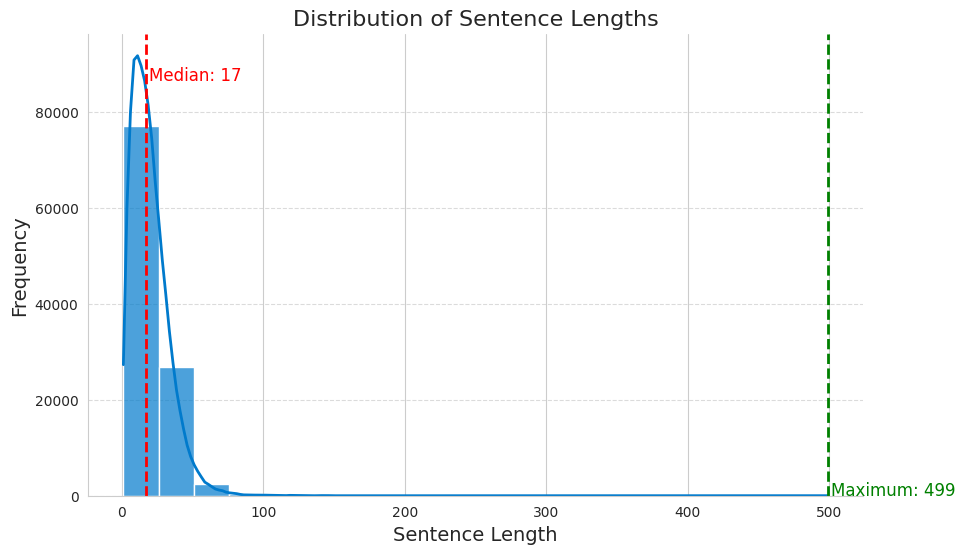

In [ ]:


# lengths' is list of sentence lengths

def visualize_sentence_lengths(lengths):

  sns.set_style("whitegrid")  # Set the overall style of the plot
  plt.figure(figsize=(10, 6))  # Adjust the figure size

  # Create the histogram with customizations
  ax = sns.histplot(
      lengths,
      bins=20,
      kde=True,
      color="#007acc",  # Change the bar color
      line_kws={"linewidth": 2},  # Adjust the KDE line width
      alpha=0.7  # Add transparency to the bars
  )

  # Add labels and title
  plt.xlabel("Sentence Length", fontsize=14)
  plt.ylabel("Frequency", fontsize=14)
  plt.title("Distribution of Sentence Lengths", fontsize=16)

  # Remove the top and right spines for a cleaner look
  sns.despine()

  # Add a grid for better readability
  plt.grid(axis="y", linestyle="--", alpha=0.7)

  # Annotate the median sentence length
  median_length = np.median(lengths)
  plt.axvline(median_length, color="red", linestyle="--", linewidth=2)
  plt.text(
      median_length + 2,
      ax.get_ylim()[1] * 0.9,
      f"Median: {median_length:.0f}",
      color="red",
      fontsize=12
  )
  # Calculate the maximum sentence length and its frequency
  max_length = max(lengths)
  max_freq = np.bincount(lengths)[max_length]

  # Annotate the maximum sentence length
  plt.axvline(max_length, color="green", linestyle="--", linewidth=2)
  plt.text(
      max_length + 2,
      max_freq,  # Position the text near the maximum frequency
      f"Maximum: {max_length:.0f}",
      color="green",
      fontsize=12,
  )

  plt.show()
visualize_sentence_lengths(lengths)

In [ ]:
#Cover most data: Aim to have a maxlen that covers a significant portion of your sentences
#to avoid excessive truncation.
#--> i think according to this graph 100 as max_length will be a good trade-off between capturing information and computational cost.
print('i think according to this graph 100 as max_length will be a good trade-off between capturing information and computational cost.')
print('\nany sequence < 100 , we will add zeros on the left side to it because 0 is  not exist in X_encoded')
print('any sequence > 100 , we will truncate  it from right side  [:100]')


i think according to this graph 100 as max_length will be a good trade-off between capturing information and computational cost.

any sequence < 100 , we will add zeros on the left side to it because 0 is  not exist in X_encoded
any sequence > 100 , we will truncate  it from right side  [:100]


In [ ]:
#Pad each sequence to MAX_SEQ_LENGTH using KERAS pad_sequences() function
#Sentences longer than MAX_SEQ_LENGTH are truncated
#Sentences shorter than MAX_SEQ_LENGTH are padded with zeros

#Truncation and padding can either be 'pre' or 'post'
# for padding we are using 'pre' padding type , that is add zeros on the left side
# for truncation , we are using 'post' , that is , truncate a sentence from right side

print(f'number of input sequences length less than 100 =  {len([len(x) for x in X_encoded if len(x) < 100])}\n')
print(f'number of input sequences length greater  than 100 =  {len([len(x) for x in X_encoded if len(x) > 100])}\n')

MAX_SEQ_LENGTH = 100

X_padded = pad_sequences(X_encoded , maxlen=MAX_SEQ_LENGTH , padding='pre' , truncating='post')
Y_padded = pad_sequences(Y_encoded , maxlen=MAX_SEQ_LENGTH , padding='pre' , truncating='post')


number of input sequences length less than 100 =  106631

number of input sequences length greater  than 100 =  104



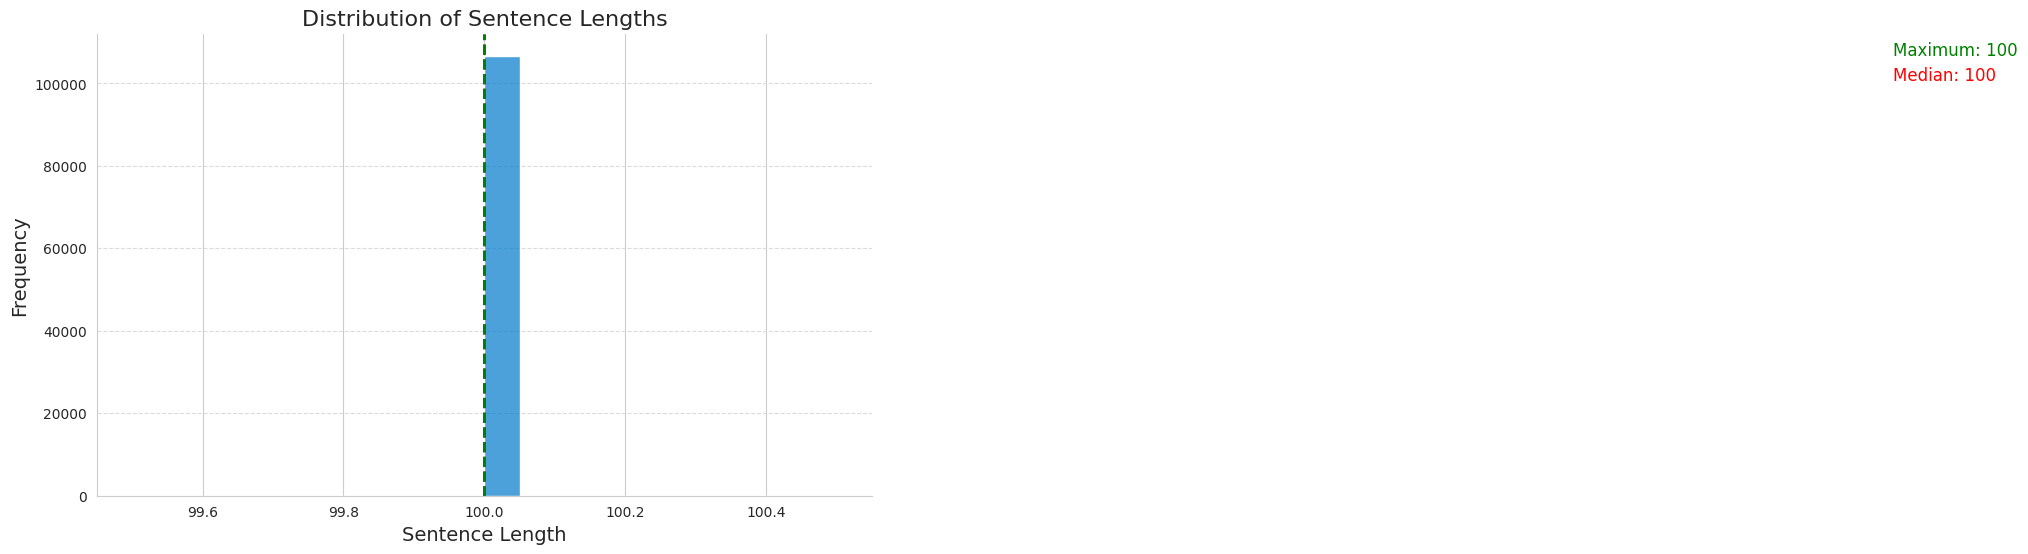

In [ ]:
# check the lengths of longest sentence
lengths_padded = [len(seq) for seq in X_padded]
visualize_sentence_lengths(lengths_padded)

In [ ]:
# make sure that each sequence of input and output is same length and all are 100

different_length = [1 if (len(input) != len(output) and len(input)==100 )  else 0 for input,output  in zip(X_padded,Y_padded)]

print(f'{sum(different_length)} sentences have disparate input and output lengths and not padded ')

0 sentences have disparate input and output lengths and not padded 


In [ ]:
# print the first sequence
print(X_padded[0],"\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  7796 29325
     2  9149   111   191     2    46  1555     1   296    18     7 16302
   739  2337  2163     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [ ]:
# assign padded sequences to X and Y
X , Y  = X_padded , Y_padded

## word embeddings  
Currently , each word and each tag is encoded as an integar .
we will use word embeddings technique to represent the input words (X) for some reasons .

####Encoding vs. Embeddings

####Integer Encoding:
When you encode words and tags as integers, you're essentially giving each unique word or tag a numerical identifier. This allows your model to process them as inputs, but it doesn't capture any semantic or contextual information about the words themselves.

####Word Embeddings:
on the other hand, are dense vector representations of words that capture semantic relationships and contextual information. They map words to a continuous vector space where similar words have similar vector representations.

####Why Word Embeddings Are Important

Even though integer encoding allows your model to process words, using word embeddings provides several advantages:

Semantic Representation: Word embeddings encode the meaning of words in a way that allows the model to understand relationships between them. For example, the embeddings for "king" and "queen" would be closer in vector space than the embeddings for "king" and "table."

Contextual Information: Depending on the type of embedding (e.g., Word2Vec, GloVe, BERT), word embeddings can also capture contextual information about how words are used in different sentences and contexts.

#### Choosing the dimension of your word embeddings :

Imagine a 2-dimensional space (like a graph). Each word would be represented by a point with two coordinates (x and y). If you increase the dimensionality to 3, you're essentially adding a z-axis, and each word would have three coordinates (x, y, z).

Word embeddings typically have much higher dimensionality (e.g., 100, 200, 300, or more). It's difficult to visualize these high-dimensional spaces directly, but the concept remains the same: each word is a point with a certain number of coordinates, and that number is the dimensionality of the embedding.

####Why Dimensionality Matters

Information Capacity: Higher dimensionality allows for encoding more information about each word, potentially capturing finer-grained semantic relationships and nuances.


Computational Cost: Higher dimensionality increases the computational burden on your model, requiring more memory and processing time.


Generalization: The dimensionality can affect the model's ability to generalize to unseen words.
Choosing the Right Dimensionality

There's no one-size-fits-all answer for the best dimensionality. It depends on your specific dataset, task, and computational resources. You'll typically need to experiment with different dimensions and evaluate their performance on your task.

Conclusion :

Dimensionality of word embeddings simply refers to the number of elements in each word's vector representation.
It represents the amount of information that can be encoded about each word.
Choosing the right dimensionality is a balance between information capacity, computational cost, and generalization ability. I hope this clarifies the concept of dimensionality in word embeddings

####In the context of your POS tagging code:

Word embeddings can help your model understand the semantic relationships between words, which is crucial for POS tagging. For example, knowing that "run" is a verb and "running" is a noun (or verb, depending on context) can be encoded in their embeddings.
They can improve the accuracy of your tagger by providing more information about the words in the input sequence.

####Mathematical Representation

Let's say you have a vocabulary of V unique words. A word embedding for a word w can be represented as:

w = [w1, w2, w3, ..., wd]

where:

w is the embedding vector for word w.
w1, w2, w3, ..., wd are the individual components or dimensions of the vector.
d is the dimensionality of the embedding space.

####Semantic Similarity:
 Words with similar meanings tend to have embedding vectors that are close together in the embedding space. This is measured using metrics like cosine similarity.

Cosine Similarity( u, v ) = ( u • v ) / ( || u || * || v || )

where:

u and v are two embedding vectors.
• represents the dot product.

|| u || and || v || represent the magnitudes of the vectors.
####Linear Relationships:
 Word embeddings often exhibit interesting linear relationships. For example, the famous analogy:

king - man + woman ≈ queen

This means that if you subtract the embedding vector for "man" from the embedding vector for "king" and add the embedding vector for "woman," the resulting vector is close to the embedding vector for "queen."


## why not one_hot encoder instead of word_embedding ?

While one-hot encoding is a simple and straightforward way to represent words numerically, it has several limitations that make it a poor substitute for word embeddings in most NLP tasks:

####High Dimensionality:
One-hot encoding creates extremely high-dimensional vectors, especially with large vocabularies. This can lead to:

Increased computational cost: More memory and processing time are required to handle these large vectors in our case our voccabulary size is 73104.

Sparsity issues: The vectors are mostly filled with 0s, which can make them inefficient for many machine learning algorithms.

####Increased computational cost:
More memory and processing time are required to handle these large vectors.
Sparsity issues: The vectors are mostly filled with 0s, which can make them inefficient for many machine learning algorithms.

Lack of Semantic Relationships: One-hot encoding doesn't capture any relationships between words. Every word is treated as independent and equally distant from every other word. This means the model can't leverage the semantic similarities between words to improve its understanding of the text.




-->Initially, we had 12 distinct POS tags in our dataset. To handle varying sentence lengths during the padding process, we introduced a padding character represented by '0'. This addition brings the total number of unique tags to 13. Given this relatively small vocabulary size for our target variable (POS tags), we can efficiently utilize one-hot encoding. This approach involves representing each tag as a 13-dimensional vector, where only one element is '1' (indicating the specific tag) while the rest are '0'. Despite the simplicity of one-hot encoding, it's well-suited for this scenario because POS tags represent distinct grammatical categories without inherent semantic relationships. While one-hot vectors might not explicitly capture such relationships, the LSTM network possesses the capability to learn its own representations of these tags during the training process. Consequently, the LSTM can effectively associate specific patterns within the input word sequence with the corresponding one-hot encoded POS tags, ultimately enabling accurate POS tagging.

#### to use word embeddings , you can go for either of the following models  
1 . word2vec model


2 . GloVe model

Dimension of a word embedding is (Voccabularry_size , Embedding_Dimension )


In [ ]:
# Download the pre-trained Word2Vec model (GoogleNews-vectors-negative300)
Word2Vec = api.load('word2vec-google-news-300')



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#word2vec effectivness
Word2Vec.most_similar(positive=['King','Woman'] , negative=['Man'])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.4422132968902588),
 ('Jackson', 0.440250426530838),
 ('NECN_Alison', 0.4331282675266266),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [ ]:
#assign word vectors from word2vec model

EMBEDDING_SIZE = 300 # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matrix

embedding_weights = np.zeros((VOCABULARY_SIZE , EMBEDDING_SIZE))

# create a word to index dictionnary mapping

word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words in the corpus

for word , index in word2id.items():
  if word in Word2Vec.key_to_index:
    try:
      embedding_weights[index, :] = Word2Vec[word]
    except KeyError:
      pass






In [ ]:
# check embedding dimension
print(f"Embedding shape : {embedding_weights.shape} ")

Embedding shape : (73105, 300) 


In [ ]:
# let's look at an embedding of a word

embedding_weights[word_tokenizer.word_index['joy']]



array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

### Use one-hot encoding for output sequences (Y)

In [ ]:
# use Keras to categorical function to one-hot encode Y
Y = to_categorical(Y)

In [ ]:
# print Keras' to_categorical function to one-hot encode Y
Y.shape

(106736, 100, 13)

In [ ]:
X.shape

(106736, 100)

## Split data in training , validation , testing sets

In [ ]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size=TEST_SIZE , random_state=42)

In [ ]:
# Split training data into training and validation sets
VALIDATION_SIZE = 0.15
X_train , X_val , Y_train , Y_val = train_test_split(X_train , Y_train , test_size=VALIDATION_SIZE , random_state=42)


In [ ]:
# print number of samples in each sets
print("Training Data : ")
print(f"Shape of input Sequence : {X_train.shape}")
print(f"Shape of output Sequence : {Y_train.shape}")
print("_"*50)
print("Validation Data : ")
print(f"Shape of input Sequence : {X_val.shape}")
print(f"Shape of output Sequence : {Y_val.shape}")
print("_"*50)
print("Testing Data : ")
print(f"Shape of input Sequence : {X_test.shape}")
print(f"Shape of output Sequence : {Y_test.shape}")
print("_"*50)


Training Data : 
Shape of input Sequence : (77116, 100)
Shape of output Sequence : (77116, 100, 13)
__________________________________________________
Validation Data : 
Shape of input Sequence : (13609, 100)
Shape of output Sequence : (13609, 100, 13)
__________________________________________________
Testing Data : 
Shape of input Sequence : (16011, 100)
Shape of output Sequence : (16011, 100, 13)
__________________________________________________


### Before using RNN , we must make sure the dimensions of the data are what the RNN expects , in general , an RNN expects the following shape
#### Shape of X : (#samples , #timesteps , #features)
#### Shape of Y : (#samples , #timesteps , #features)

Our input data X currently has the shape (106736, 100), representing 106,736 samples, each with a sequence length of 100. RNNs can accept various input shapes depending on the specific architecture. Since we're dealing with a many-to-many problem where both input and output sequences have the same length (timesteps), the input shape is suitable.

Notice that X only has two dimensions. The missing third dimension, representing the number of features, will be automatically handled by the Embedding layer in Keras. This layer transforms the input data into the expected format of (#samples, #timesteps, #features), where #features corresponds to the embedding dimension. Therefore, there's no need to explicitly reshape the data beforehand when using an Embedding layer as the first layer in our RNN.

However, if you were to use an RNN without an Embedding layer, you would need to reshape the input data to include the feature dimension explicitly, resulting in the shape (#samples, #timesteps, #features) embedding layer always the first layer of RNN ) while using the embedding layer we only need to reshape the data to (#samples , #timesteps,#features) which what have done . however note you will need to shape it (#samples , #timesteps, #features ) in case you don't use the Embedding() layer in keras .

## vanilla RNN

When building our RNN model , we are going to use word embedding to represent the word , now when training the model , you can also train the word embedding as well along the network weights . these are often called embedding weights .
while training the embedding weights will be treated as normal weighs of the network which will be updated at every iteration so we will experiment three situation :            

Three Scenarios for Training Word Embeddings
You're exploring different approaches to using word embeddings in your RNN model, focusing on whether the embedding weights are trainable or not. This is an important consideration as it can impact the performance and adaptability of your model. Here's a breakdown of the three scenarios:

###1. RNN + Arbitrarily Initialized Untrainable Embedding

Embedding Initialization:

In this case, initialize the embedding weights randomly or using some predefined scheme.

Trainability: The key here is that these embedding weights are set to be untrainable. This means that during the training process, the weights of the embedding layer will remain fixed. They won't be updated based on the training data.

Advantages: This approach can be useful when you have limited training data or want to prevent the embeddings from overfitting to your specific dataset. It also reduces the number of parameters to train, potentially speeding up the training process.

Disadvantages: The embeddings might not be optimal for your specific task, as they are not adapted to the nuances of your data. This could lead to lower performance compared to trainable embeddings.


###2. RNN + Arbitrarily Initialized Trainable Embedding
Embedding Initialization:

Similar to the previous scenario, the embedding weights are initialized randomly or with a predefined scheme.


Trainability: However, in this case, the embedding weights are set to be trainable. This means they will be updated during the training process alongside the other weights of your RNN model.


Advantages: This approach allows the embeddings to adapt to your specific dataset, potentially leading to better performance. It provides more flexibility for the model to learn relevant representations of words within the context of your task.


Disadvantages: This increases the number of parameters to train, which can make the training process more computationally expensive and potentially increase the risk of overfitting.


###3. RNN + Trainable Word2Vec Embedding
Embedding Initialization:

Instead of random initialization, you'll use pre-trained Word2Vec embeddings as the initial values for your embedding layer. This provides a starting point with embeddings that have already captured semantic relationships from a large corpus of text.


Trainability: You'll make these Word2Vec embeddings trainable during the training of your RNN.


Advantages: This approach combines the benefits of pre-trained embeddings with the adaptability of trainable weights. You start with a strong foundation of semantic knowledge from Word2Vec and then fine-tune the embeddings to your specific task and dataset. This can lead to faster convergence during training and potentially improved performance.


Disadvantages: As with other trainable embeddings, there's a risk of overfitting if you have a limited dataset.

# 1 Arbitrarily Initialized Untrainable Embedding

First let's try running a vanilla RNN , for this RNN we won't use the pre-trained word embeddings . we will use randomly initialised embeddings . moreover , we won't update the embeddings weights .

In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]


In [ ]:
NUM_CLASSES

13

In [ ]:
MAX_SEQ_LENGTH

100

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed

# create architecture
from tensorflow.keras import backend as K
K.clear_session()

rnn_model = Sequential()

# create embedding Layer - usually the first layer in text problems

rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = False # False - don't update the embeddings weights

))

# add an RNN layer which  contains 64 RNN cells

rnn_model.add(SimpleRNN(64,
                        return_sequences=True # True : return whole sequence ; False : only return the songle output
))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### compile model

In [ ]:
rnn_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])


# Build the computational graph it's essential to :
#Model Summary: Calling build() is necessary to generate the model summary (rnn_model.summary()),
#which provides a detailed overview of the model's structure and parameters.
#Weight Initialization: Before training, the model's weights need to be initialized.
#build() ensures this initialization happens correctly based on the specified input shape.
#Graph Completion: The computational graph is a representation of the model's operations.
#Building it with build() makes the model ready for training and prediction.


rnn_model.build(input_shape=(None, 100))



In [ ]:
# check the summary of the model
rnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100, 64)             │          23,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,955,705 (83.75 MB)

 Trainable params: 24,205 (94.55 KB)

 Non-trainable params: 21,931,500 (83.66 MB)

## Fit Model

rnn_training =: This part assigns the result of the training process to the variable rnn_training. This result typically contains information about the model's performance during training, such as loss and accuracy over each epoch.

rnn_model.fit(): fit() is a function that is central to training machine learning models in Keras (a deep learning library). It's the method you call to start the learning process.

X_train: This is the training data containing the input sequences (encoded and padded sentences) that the model will learn from.

Y_train: This is the training data containing the corresponding target values or labels (one-hot encoded POS tags) for each input sequence in X_train. The model learns to predict these target values.

batch_size=128: This argument controls how many samples (sentences, in this case) are processed before the model's internal parameters are updated. A batch size of 128 means the model will see 128 sentences before making adjustments to its weights.

epochs=10: This argument specifies the number of times the entire training dataset (X_train and Y_train) will be passed through the model during training. Each complete pass through the dataset is called an epoch.

validation_data=(X_val , Y_val): This argument provides a separate set of data (X_val and Y_val), called the validation set, that the model is evaluated on after each epoch. This helps you monitor how well the model is generalizing to unseen data and prevents overfitting (where the model learns the training data too well but doesn't perform well on new data).

In [ ]:
rnn_training = rnn_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 164s 256ms/step - acc: 0.8428 - loss: 0.6196 - val_acc: 0.9124 - val_loss: 0.2757
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 163s 191ms/step - acc: 0.9234 - loss: 0.2482 - val_acc: 0.9422 - val_loss: 0.1887
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 125s 208ms/step - acc: 0.9442 - loss: 0.1793 - val_acc: 0.9503 - val_loss: 0.1559
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 149s 219ms/step - acc: 0.9509 - loss: 0.1526 - val_acc: 0.9549 - val_loss: 0.1388
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 142s 218ms/step - acc: 0.9553 - loss: 0.1367 - val_acc: 0.9573 - val_loss: 0.1291
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 124s 189ms/step - acc: 0.9576 - loss: 0.1279 - val_acc: 0.9590 - val_loss: 0.1234
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 123s 203ms/step - acc: 0.9593 - loss: 0.1218 - val_acc: 0.9602 - val_loss: 0.1186
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 138s 197ms/step - acc: 0.9603 - loss: 0.1178 - val_acc: 0.9607 - val_loss: 0.1156
Epoch 9/10
603/603 ━━━━━

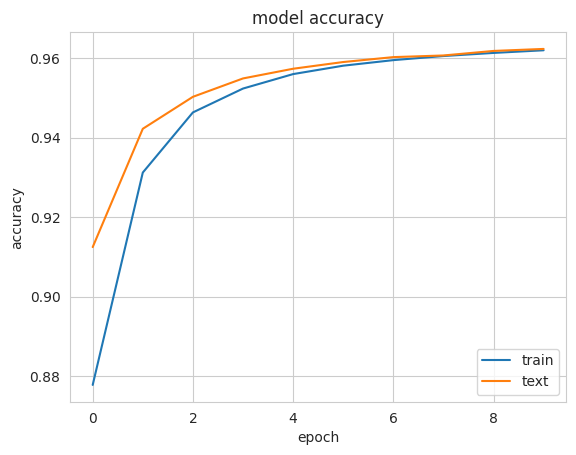

In [ ]:
# visualise training history
#rnn_training.history['acc']: Represents the training accuracy recorded during each epoch of training.
#It shows how well the model is performing on the training data as training progresses.
#rnn_training.history['val_acc']: Represents the validation accuracy recorded during each epoch of training.
#It indicates how well the model is generalizing to the unseen data in the validation set.
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()


# 2 . RNN + Arbitrarily (Randomly) Initialized Trainable Embedding

---



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed

# create architecture
from tensorflow.keras import backend as K
K.clear_session()

rnn_model = Sequential()

# create embedding Layer - usually the first layer in text problems

rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = True # False - don't update the embeddings weights

))

# add an RNN layer which  contains 64 RNN cells

rnn_model.add(SimpleRNN(64,
                        return_sequences=True # True : return whole sequence ; False : only return the songle output
))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## compile the model

In [ ]:

rnn_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
rnn_model.build(input_shape=(None, 100))



In [ ]:
# check the summary of the model
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100, 64)             │          23,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,955,705 (83.75 MB)

 Trainable params: 21,955,705 (83.75 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model


In [ ]:
rnn_training = rnn_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 349s 566ms/step - acc: 0.9383 - loss: 0.2447 - val_acc: 0.9884 - val_loss: 0.0338
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 385s 571ms/step - acc: 0.9902 - loss: 0.0276 - val_acc: 0.9894 - val_loss: 0.0287
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 402s 604ms/step - acc: 0.9921 - loss: 0.0209 - val_acc: 0.9897 - val_loss: 0.0277
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 364s 574ms/step - acc: 0.9932 - loss: 0.0179 - val_acc: 0.9897 - val_loss: 0.0281
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 393s 593ms/step - acc: 0.9942 - loss: 0.0154 - val_acc: 0.9897 - val_loss: 0.0292
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 354s 587ms/step - acc: 0.9952 - loss: 0.0130 - val_acc: 0.9895 - val_loss: 0.0310
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 347s 529ms/step - acc: 0.9961 - loss: 0.0110 - val_acc: 0.9893 - val_loss: 0.0331
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 318s 522ms/step - acc: 0.9969 - loss: 0.0090 - val_acc: 0.9890 - val_loss: 0.0359
Epoch 9/10
603/603 ━━━━━

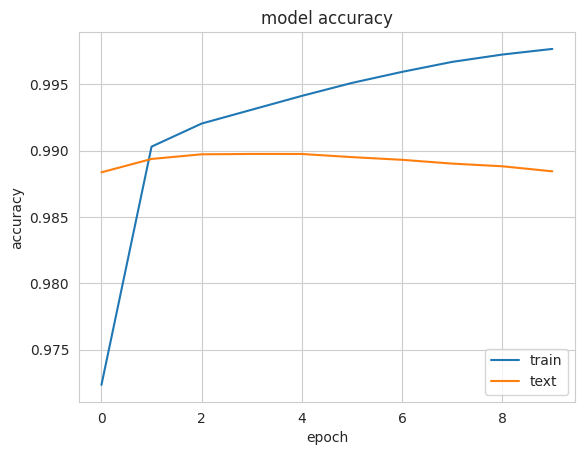

In [ ]:
# visualise the training process
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()

# RNN + Trainable Word2Vec Embedding
Using pre_trained embedding weights

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed

# create architecture
from tensorflow.keras import backend as K
K.clear_session()

rnn_model = Sequential()

# create embedding Layer - usually the first layer in text problems

rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = True, # False - don't update the embeddings weights
                       weights=[embedding_weights]


))

# add an RNN layer which  contains 64 RNN cells

rnn_model.add(SimpleRNN(64,
                        return_sequences=True # True : return whole sequence ; False : only return the songle output
))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

rnn_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Compile model

In [ ]:

rnn_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
rnn_model.build(input_shape=(None, 100))

In [ ]:
# check the summary of the model
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100, 64)             │          23,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,955,705 (83.75 MB)

 Trainable params: 21,955,705 (83.75 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model

In [ ]:
rnn_training = rnn_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 518ms/step - acc: 0.9551 - loss: 0.2157 - val_acc: 0.9891 - val_loss: 0.0310
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 312s 518ms/step - acc: 0.9907 - loss: 0.0259 - val_acc: 0.9899 - val_loss: 0.0269
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 311s 516ms/step - acc: 0.9921 - loss: 0.0205 - val_acc: 0.9902 - val_loss: 0.0261
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 323s 518ms/step - acc: 0.9932 - loss: 0.0179 - val_acc: 0.9904 - val_loss: 0.0260
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 313s 520ms/step - acc: 0.9942 - loss: 0.0155 - val_acc: 0.9904 - val_loss: 0.0265
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 517ms/step - acc: 0.9952 - loss: 0.0132 - val_acc: 0.9904 - val_loss: 0.0277
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 321s 515ms/step - acc: 0.9959 - loss: 0.0114 - val_acc: 0.9901 - val_loss: 0.0295
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 323s 516ms/step - acc: 0.9966 - loss: 0.0096 - val_acc: 0.9901 - val_loss: 0.0310
Epoch 9/10
603/603 ━━━━━

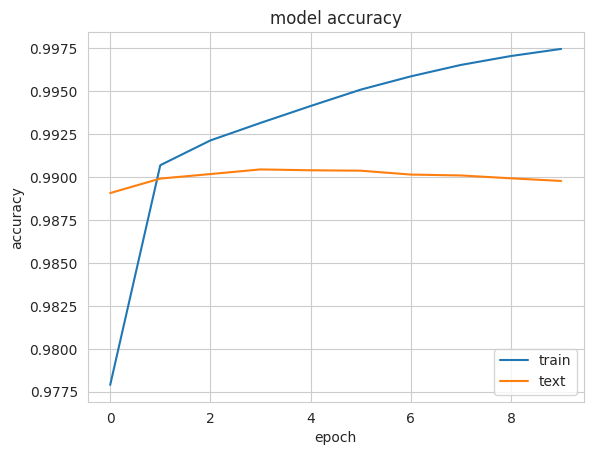

In [ ]:
# visualise the training process
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()

# LSTM:
we will pre_trained word embeddings in the following models and allow them to be updated as well

In [ ]:

LSTM_model = Sequential()

# create embedding Layer - usually the first layer in text problems

LSTM_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = True, # False - don't update the embeddings weights
                       weights=[embedding_weights]


))

# add an RNN layer which  contains 64 RNN cells

LSTM_model.add(LSTM(64,
                        return_sequences=True # True : return whole sequence ; False : only return the songle output
))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

LSTM_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


## compile the model

In [ ]:
LSTM_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
LSTM_model.build(input_shape=(None, 100))

In [ ]:
# check the summary of the model
LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,025,785 (84.02 MB)

 Trainable params: 22,025,785 (84.02 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model

In [ ]:
LSTM_training = LSTM_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 420s 684ms/step - acc: 0.9345 - loss: 0.2624 - val_acc: 0.9890 - val_loss: 0.0314
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 409s 677ms/step - acc: 0.9902 - loss: 0.0272 - val_acc: 0.9901 - val_loss: 0.0265
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 407s 675ms/step - acc: 0.9917 - loss: 0.0215 - val_acc: 0.9905 - val_loss: 0.0252
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 411s 681ms/step - acc: 0.9929 - loss: 0.0187 - val_acc: 0.9910 - val_loss: 0.0245
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 414s 687ms/step - acc: 0.9941 - loss: 0.0160 - val_acc: 0.9911 - val_loss: 0.0245
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 440s 684ms/step - acc: 0.9950 - loss: 0.0139 - val_acc: 0.9912 - val_loss: 0.0249
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 441s 682ms/step - acc: 0.9956 - loss: 0.0121 - val_acc: 0.9911 - val_loss: 0.0259
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 441s 681ms/step - acc: 0.9962 - loss: 0.0106 - val_acc: 0.9910 - val_loss: 0.0270
Epoch 9/10
603/603 ━━━━━

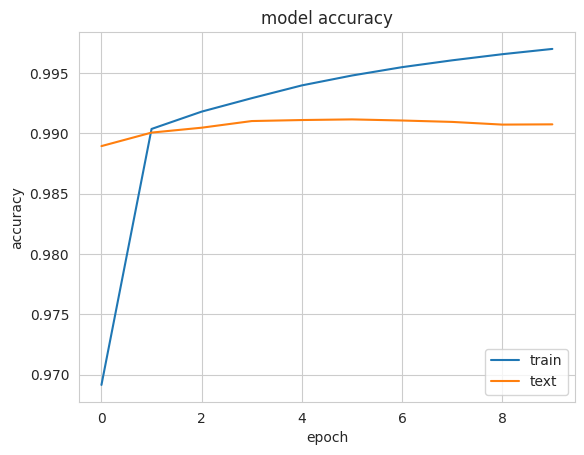

In [ ]:
# visualise the training process
plt.plot(LSTM_training.history['acc'])
plt.plot(LSTM_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()

# GRU

In [ ]:

GRU_model = Sequential()

# create embedding Layer - usually the first layer in text problems

GRU_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = True, # False - don't update the embeddings weights
                       weights=[embedding_weights]


))

# add an RNN layer which  contains 64 RNN cells

GRU_model.add(GRU(64,
                        return_sequences=True # True : return whole sequence ; False : only return the songle output
))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

GRU_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## compile the model

In [ ]:
GRU_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
GRU_model.build(input_shape=(None, 100))

In [ ]:
# check the summary of the model
GRU_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100, 64)             │          70,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 100, 13)             │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,002,617 (83.93 MB)

 Trainable params: 22,002,617 (83.93 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model

In [ ]:
GRU_training = GRU_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 421s 684ms/step - acc: 0.9562 - loss: 0.1986 - val_acc: 0.9893 - val_loss: 0.0286
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 437s 677ms/step - acc: 0.9906 - loss: 0.0247 - val_acc: 0.9901 - val_loss: 0.0256
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 411s 681ms/step - acc: 0.9919 - loss: 0.0204 - val_acc: 0.9904 - val_loss: 0.0249
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 408s 677ms/step - acc: 0.9928 - loss: 0.0180 - val_acc: 0.9909 - val_loss: 0.0244
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 448s 688ms/step - acc: 0.9938 - loss: 0.0160 - val_acc: 0.9912 - val_loss: 0.0242
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 449s 699ms/step - acc: 0.9947 - loss: 0.0140 - val_acc: 0.9913 - val_loss: 0.0249
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 416s 691ms/step - acc: 0.9954 - loss: 0.0123 - val_acc: 0.9913 - val_loss: 0.0257
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 445s 695ms/step - acc: 0.9960 - loss: 0.0109 - val_acc: 0.9911 - val_loss: 0.0272
Epoch 9/10
603/603 ━━━━━

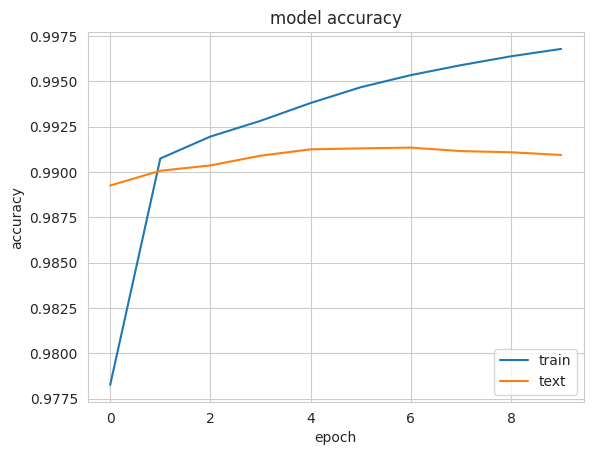

In [ ]:
# visualise the training process
plt.plot(GRU_training.history['acc'])
plt.plot(GRU_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()

# 3 . Bidirectional LSTM
----------------------------------------------------------

In [ ]:

bidirect_model = Sequential()

# create embedding Layer - usually the first layer in text problems

bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE, # vocabulary size - number of unique words in data
                       output_dim = EMBEDDING_SIZE,# length of vector with which each word is represented
                       input_length = MAX_SEQ_LENGTH,#length of input sequence
                       trainable = True, # False - don't update the embeddings weights
                       weights=[embedding_weights]


))

# add an RNN layer which  contains 64 RNN cells

bidirect_model.add(Bidirectional(LSTM(64,
                        return_sequences=True # True : return whole sequence ; False : only return the single output
)))

# add time distributed (output at each sequence ) layer
# The TimeDistributed layer is used to apply a Dense layer to each time step of the RNN's output,
#  allowing you to get predictions for each word in the sequence.

bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES , activation='softmax')))


## complile the model

In [ ]:
bidirect_model.compile(loss ='categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])
bidirect_model.build(input_shape=(None, 100))

In [ ]:
# check the summary of the model
bidirect_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 300)            │      21,931,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 100, 13)             │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,120,057 (84.38 MB)

 Trainable params: 22,120,057 (84.38 MB)

 Non-trainable params: 0 (0.00 B)

## Fit the model


In [ ]:
bidirect_model_training = bidirect_model.fit(X_train , Y_train , batch_size=128 , epochs=10 , validation_data=(X_val , Y_val))

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - acc: 0.9342 - loss: 0.2199 - val_acc: 0.9911 - val_loss: 0.0249
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - acc: 0.9924 - loss: 0.0211 - val_acc: 0.9923 - val_loss: 0.0213
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - acc: 0.9942 - loss: 0.0157 - val_acc: 0.9929 - val_loss: 0.0200
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - acc: 0.9956 - loss: 0.0124 - val_acc: 0.9934 - val_loss: 0.0193
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - acc: 0.9968 - loss: 0.0096 - val_acc: 0.9936 - val_loss: 0.0197
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - acc: 0.9976 - loss: 0.0074 - val_acc: 0.9936 - val_loss: 0.0205
Epoch 7/10
516/603 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - acc: 0.9983 - loss: 0.0056

In [ ]:
# visualise the training process
plt.plot(bidirect_model_training.history['acc'])
plt.plot(bidirect_model_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train' ,'text'],loc="lower right")
plt.show()

# 5. Model Evaluation



In [ ]:
loss , accuracy = rnn_model.evaluate(X_test , Y_test)
print(f'Loss : {loss} \n  Accuracy {accuracy}')

501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - acc: 0.9898 - loss: 0.0357
Loss : 0.03606339544057846 
  Accuracy 0.9896414279937744


In [ ]:
loss , accuracy = LSTM_model.evaluate(X_test , Y_test)
print(f'Loss : {loss} \n  Accuracy {accuracy}')

501/501 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - acc: 0.9908 - loss: 0.0305
Loss : 0.030792534351348877 
  Accuracy 0.990620493888855


In [ ]:
loss , accuracy = GRU_model.evaluate(X_test , Y_test)
print(f'Loss : {loss} \n  Accuracy {accuracy}')

In [ ]:
loss , accuracy = bidirect_model.evaluate(X_test , Y_test)
print(f'Loss : {loss} \n  Accuracy {accuracy}')

## Save the models

In [ ]:
rnn_model.save('rnn_model.keras')
LSTM_model.save('lstm_model.keras')
#GRU_model.save('gru_model.keras')
#bidirect_model.save('bidirect_model.keras')

print("Models saved successfully!")

Models saved successfully!


In [ ]:
rnn_predictions = rnn_model.predict(X_test)



501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


In [ ]:
rnn_predictions.shape

(16011, 100, 13)

In [ ]:

rnn_labels = np.argmax(rnn_predictions, axis=-1)
rnn_labels.shape


(16011, 100)

In [ ]:
predicted_tags = [[tag_tokenizer.index_word.get(tag_index, 'PAD') for tag_index in sentence] for sentence in rnn_labels]
predicted_tags = [[tag for tag in sentence if tag != 'PAD'] for sentence in predicted_tags]


# Decode X_test (convert numerical sequences back to words)
X_test_decoded = word_tokenizer.sequences_to_texts(X_test)

# Print X_test with predicted tags
for words, tags in zip(X_test_decoded[:500], predicted_tags[:500]):
    print(f"Words: {words}")
    print(f"Predicted Tags: {tags}\n")

Words: his fatigues made a streak of almost phosphorescent green in the mist .
Predicted Tags: ['det', 'noun', 'verb', 'det', 'noun', 'adp', 'adv', 'adv', 'noun', 'adp', 'det', 'noun', '.']

Words: but it is worth pondering that very little has been published on any phase of field techniques in linguistics .
Predicted Tags: ['conj', 'pron', 'verb', 'adj', 'verb', 'adp', 'adv', 'adv', 'verb', 'verb', 'verb', 'adp', 'det', 'noun', 'adp', 'noun', 'noun', 'adp', 'noun', '.']

Words: everywhere else his ideas lay or hung in visible form : his models , drawings , ten-foot canvases in monochromes from his painting days , and underfoot a windfall of broken-backed books that looked as though their insides had been ransacked by a maniac .
Predicted Tags: ['adv', 'adv', 'det', 'noun', 'verb', 'conj', 'verb', 'adp', 'adj', 'noun', '.', 'det', 'noun', '.', 'noun', '.', 'adv', 'noun', 'adp', 'adj', 'adp', 'det', 'noun', 'noun', '.', 'conj', 'adv', 'det', 'noun', 'adp', 'noun', 'noun', 'adp', 'verb',

In [ ]:
X_test.shape

(16011, 100)

In [1]:
# input a text and test this model
sentence = input('write your sentence : \n')
sentence_encoded = word_tokenizer.texts_to_sequences([sentence])
sentence_padded = pad_sequences(sentence_encoded, maxlen=max_length, padding='pre', truncating='post')
predictions = rnn_model.predict(sentence_padded)
predicted_labels = np.argmax(predictions, axis=-1)
# Decode predictions to POS tags
predicted_tags = [tag_tokenizer.index_word.get(tag_index, 'PAD') for tag_index in predicted_labels[0]]
predicted_tags = [tag for tag in predicted_tags if tag != 'PAD']
predicted_tags

write your sentence : 
hello mr brown


NameError: name 'word_tokenizer' is not defined